In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import warnings 
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
warnings.filterwarnings("ignore")

In [9]:
all_data = pd.read_csv("datasets/forest_dataset.csv")

In [10]:
all_data.shape

(10000, 55)

In [11]:
labels = all_data[all_data.columns[-1]].values
feature_matrix = all_data[all_data.columns[:-1]].values

In [12]:
labels.shape, feature_matrix.shape

((10000,), (10000, 54))

In [13]:
train_feature_matrix, test_feature_matrix, train_labels, test_labels = train_test_split(
    feature_matrix, labels, test_size=0.2, random_state=42)

# Homework

The quality of classification/regression by the k Nearest Neighbors method depends on several parameters:
* the number of neighbors `n_neighbors`
* the distance metric between objects `metric`
* the weights of neighbors (the neighbors of the test example can enter with different weights, for example, the further the example, the less its "voice" is taken into account) `weights`


Train the `KNeighborsClassifier` on the dataset.

In [14]:
clf = KNeighborsClassifier()
clf.fit(train_feature_matrix, train_labels)
accuracy_score(clf.predict(test_feature_matrix), test_labels)

0.7365

Let's select the parameters of our model:

* Iterate over the grid from `1` to `10` for the number of neighbors parameter
* Also, try using different metrics: `['manhattan', 'euclidean']`
* Try using different weight calculation strategies: `[‘uniform’, ‘distance’]`

In [15]:
from sklearn.model_selection import GridSearchCV
params = {
    "n_neighbors" : range(1,10) ,
    "metric" : ['manhattan', 'euclidean'],
    "weights" : ['uniform', 'distance']
}

clf_grid = GridSearchCV(clf, params, cv=3, scoring='accuracy', n_jobs=-1, verbose = 3)
clf_grid.fit(train_feature_matrix, train_labels)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['manhattan', 'euclidean'],
                         'n_neighbors': range(1, 10),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=3)

Let's output the best parameters

In [16]:
clf_grid.best_params_

{'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}

Using the optimal number of neighbors found, calculate the probabilities of belonging to classes for the test sample (`.predict_proba`).

In [17]:
optimal_clf = clf_grid.best_estimator_
pred_prob = optimal_clf.predict_proba(test_feature_matrix)

In [18]:
accuracy_score(optimal_clf.predict(test_feature_matrix), test_labels)

0.785

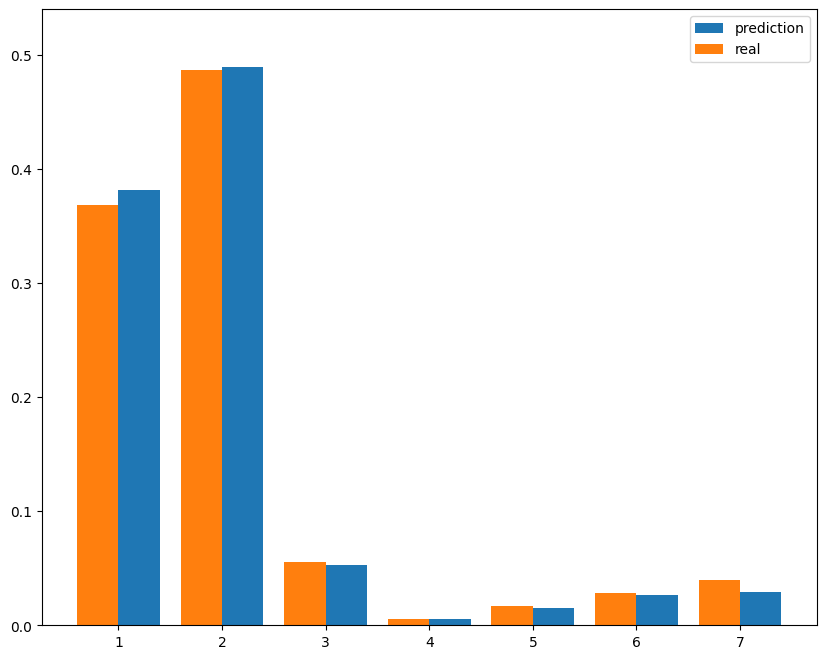

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

unique, freq = np.unique(test_labels, return_counts=True)
freq = list(map(lambda x: x / len(test_labels),freq))

pred_freq = pred_prob.mean(axis=0)
plt.figure(figsize=(10, 8))
plt.bar(range(1, 8), pred_freq, width=0.4, align="edge", label='prediction')
plt.bar(range(1, 8), freq, width=-0.4, align="edge", label='real')
plt.ylim(0, 0.54)
plt.legend()
plt.show()

## Conclusion

What is the quality of the model on the test sample? Compare it with the quality of logistic regression. Which model is better? Why? What are the pros and cons of the k Nearest Neighbors method? Plot the ROC curve for the k Nearest Neighbors method. Calculate the area under the ROC curve (AUC-ROC).

In [20]:
for average in ["macro", "micro"]:
    print(f"The result of roc_auc with one vs rest strategy and {average} average is ", 
        roc_auc_score(test_labels, pred_prob, multi_class="ovr", average=average))
print(f"The result of roc_auc with one vs one strategy and macro average is ", 
        roc_auc_score(test_labels, pred_prob, multi_class="ovo")) #micro average with one vs one is not possible

The result of roc_auc with one vs rest strategy and macro average is  0.9057501676949595
The result of roc_auc with one vs rest strategy and micro average is  0.9556655416666667
The result of roc_auc with one vs one strategy and macro average is  0.8977125968267149


In [21]:
np.unique(test_labels)

array([1, 2, 3, 4, 5, 6, 7], dtype=int64)

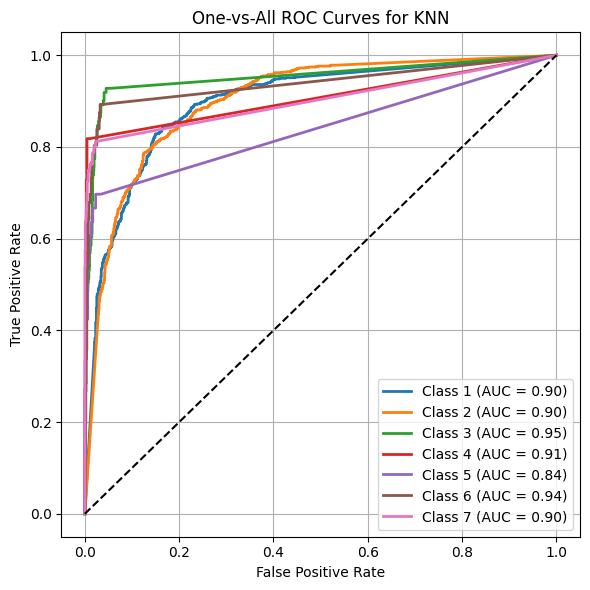

KNN Macro-AUC: 0.906
KNN Micro-AUC: 0.956
Logistic Regression AUC: 0.894


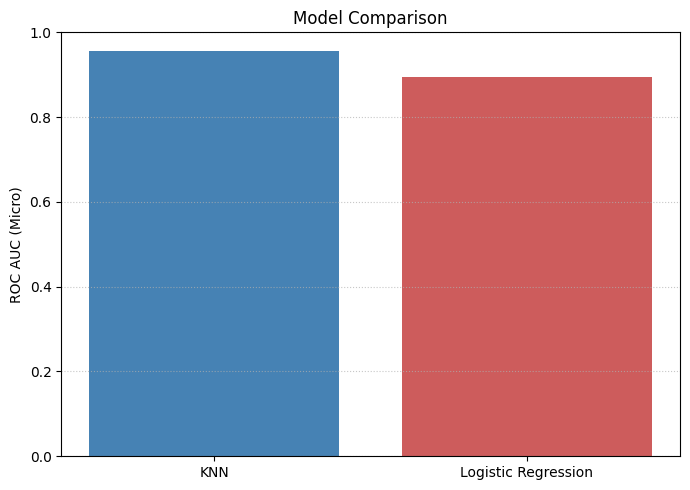

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression

def compute_roc_auc_curves(y_true, y_scores, n_classes):
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        y_true_bin = (y_true == i + 1).astype(int)
        y_score = y_scores[:, i]
        fpr[i], tpr[i], _ = roc_curve(y_true_bin, y_score)
        roc_auc[i] = auc(fpr[i], tpr[i])
    return fpr, tpr, roc_auc

def plot_roc_curves(fpr, tpr, roc_auc, title='ROC Curves'):
    plt.figure(figsize=(6, 6))
    for i in fpr:
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def compare_models_auc(micro_auc_knn, roc_auc_lr):
    plt.figure(figsize=(7, 5))
    methods = ['KNN', 'Logistic Regression']
    aucs = [micro_auc_knn, roc_auc_lr]
    colors = ['steelblue', 'indianred']
    plt.bar(methods, aucs, color=colors)
    plt.ylabel('ROC AUC (Micro)')
    plt.title('Model Comparison')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.show()

n_classes = 7
fpr_knn, tpr_knn, roc_auc_knn = compute_roc_auc_curves(test_labels, pred_prob, n_classes)

macro_auc_knn = np.mean(list(roc_auc_knn.values()))
micro_auc_knn = roc_auc_score(
    label_binarize(test_labels, classes=np.arange(1, n_classes + 1)),
    pred_prob,
    average='micro'
)

clf_lr = LogisticRegression(C=3, penalty='l2', max_iter=1000)
clf_lr.fit(train_feature_matrix, train_labels)
y_score_lr = clf_lr.predict_proba(test_feature_matrix)
roc_auc_lr = roc_auc_score(test_labels, y_score_lr, multi_class='ovr')

plot_roc_curves(fpr_knn, tpr_knn, roc_auc_knn, title='One-vs-All ROC Curves for KNN')

print(f"KNN Macro-AUC: {macro_auc_knn:.3f}")
print(f"KNN Micro-AUC: {micro_auc_knn:.3f}")
print(f"Logistic Regression AUC: {roc_auc_lr:.3f}")

compare_models_auc(micro_auc_knn, roc_auc_lr)
